In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import configs as c

/opt/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (

In [2]:
p = c.d_path
data = pd.read_csv(f"{p}testdata.csv")
print('shape:\n', data.shape)
print('info:\n', data.info())
print('desc:\n', data.describe())

shape:
 (102, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 3 columns):
emotion    102 non-null int64
pixels     102 non-null object
Usage      102 non-null object
dtypes: int64(1), object(2)
memory usage: 2.5+ KB
info:
 None
desc:
           emotion
count  102.000000
mean     3.186275
std      1.973740
min      0.000000
25%      2.000000
50%      3.000000
75%      5.000000
max      6.000000


In [3]:
data[: 3]

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training


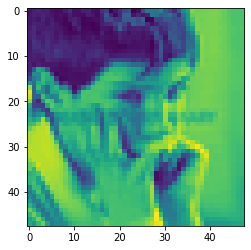

In [4]:
d1 = data['pixels'].str.split(' ')
d2 = d1.apply(lambda x: pd.Series(x))
d3 = d2.astype('int')
n_d3 = d3.values
n_d4 = n_d3.reshape((-1,48,48))
plt.imshow(n_d4[3])

In [5]:
x_train = (n_d3 / 255).reshape(-1, 48, 48, 1)

In [6]:
y_train = data['emotion']
type(y_train)

pandas.core.series.Series

In [9]:
class Model:
    """
    表情识别中使用VGGNet-16作为基本模型
    """
    def __init__(self, batch_size=32, is_training=True):
        """
        初始化类
        """
        self.epoch = 1
        self.batch_size = batch_size 
        self.is_training = is_training
        self.build_model() 
        self.init_sess() 
    def build_model(self):
        """
        构建计算图
        """
        self.graph = tf.Graph() 
        def block(net, n_conv, n_chl, blockID):
            """
            定义多个CNN组合单元
            """
            with tf.variable_scope("block%d"%blockID):
                for itr in range(n_conv):
                    net = tf.layers.conv2d(net, 
                                           n_chl, 3, 
                                           activation=tf.nn.relu, 
                                           padding="same")
                net = tf.layers.max_pooling2d(net, 2, 2)
            return net 
        
        
        """ 定义计算图 """
        with self.graph.as_default():
            # 人脸数据
            self.inputs = tf.placeholder(tf.float32, 
                                         [2, 48, 48, 1],
                                         name="inputs") 

            # 表情序列，用0-6数字表示
            self.target = tf.placeholder(tf.int32, 
                                         [2],
                                         name="target") 
            self.target_onehot = tf.one_hot(self.target, 7)
            net = tf.image.resize_images(
                self.inputs, 
                [224, 224]
            )
            net = block(net, 2, 64, 1)
            net = block(net, 2, 128, 2)
            net = block(net, 2, 256, 3)
            net = block(net, 2, 512, 4)
            net = block(net, 2, 512, 5)
            '''# 获取网络输出的shape
            # net.get_shape()
            '''
            '''
            # 输出shape转为[b, 1, 1, C]
            # net = tf.layers.average_pooling2d(net, 
            #                                  net.get_shape()[1: 3],
            #                                  padding='valid')
            '''
            net = tf.layers.flatten(net)
            net = tf.layers.dense(net, 4096, activation=tf.nn.relu)
            net = tf.layers.dense(net, 4096, activation=tf.nn.relu)
            self.logits = tf.layers.dense(net, 7, activation=None)
            # 计算loss函数
            self.loss = tf.nn.softmax_cross_entropy_with_logits_v2(
                labels=self.target_onehot, 
                logits=self.logits
            )
            accuracy = tf.equal(
                tf.argmax(self.logits, 1),
                tf.argmax(self.target_onehot, 1)
            )
            self.acc = tf.reduce_mean(tf.cast(accuracy, tf.float32))
            
            self.loss = tf.reduce_mean(self.loss)
            # 优化
            self.step = tf.train.AdamOptimizer().minimize(self.loss)
            self.shape = self.logits.shape
            # self.acc = self.accuracy(self.logits, self.target_onehot)
            self.all_var = tf.global_variables() 
            self.init = tf.global_variables_initializer() 
            self.saver = tf.train.Saver() 
    def init_sess(self, restore=None):
        """
        初始化会话
        """
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
        if restore != None:
            self.saver.restore(self.sess, restore)
    def train(self, x_train, y_train):
        for e in range(5):
            x_batch = []
            y_batch = []
            for i in range(self.batch_size):
                idx = np.random.choice(len(y_train))
                x_batch.append(x_train[idx])
                y_batch.append(y_train[idx])
            res = self.sess.run(self.acc, feed_dict={self.inputs:x_batch, self.target:y_batch})
            print(res)
                  
    def accuracy(self, logits, target):  
        correct_prediction = tf.equal(tf.argmax(target, 1), tf.argmax(logits, 1))
        return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
m = Model(batch_size=2)
m.train(x_train, y_train)